In [1]:
# Author: Ernesto Rodríguez
# github.com/ernestorodg

###############################################################################
## Analyse Bezerra's dataset for intrusion detection using Decision Trees
###############################################################################

In [2]:
import pandas as pd
import numpy as np
import sys

###############################################################################
## Define constants 
###############################################################################


# Random state for reproducibility
STATE = 0
np.random.seed(10)
# List of available attacks on the dataset


# Especific to the repository 
DATASET_DIRECTORY = r'../datasets/Dataset-bezerra-IoT-20200528T203526Z-001/Dataset-IoT/'
NETFLOW_DIRECTORY = r'NetFlow/'


# There are different csv files on the Dataset, with different types of data:

# Some meanings:
# MC: Media Center
# I: One hour of legitimate and malicious NetFlow data from profile.
# L: One hour of legitimate NetFlow data from profile.

MC = r'MC/'
ST = r'ST/'
SC = r'SC/'


# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets 
MC_I_FIRST = r'MC_I1.csv'

# MC_I_SECOND: Has infected data from Mirai botnets
MC_I_SECOND = r'MC_I2.csv'

# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
MC_I_THIRD = r'MC_I3.csv'

# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'


# Constants for ST
ST_I_FIRST = r'ST_I1.csv'
ST_I_SECOND = r'ST_I2.csv'
ST_I_THIRD = r'ST_I3.csv'
ST_L = r'ST_L.csv'

# Constants for SC
SC_I_FIRST = r'SC_I1.csv'
SC_I_SECOND = r'SC_I2.csv'
SC_I_THIRD = r'SC_I3.csv'
SC_L = r'SC_L.csv'


In [21]:
###############################################################################
## Load dataset
###############################################################################

# For MC data:
df_mc_I_first = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_FIRST)
df_mc_I_second = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_SECOND)
df_mc_I_third = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_mc = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_L)

###################

# For ST data:
df_st_I_first = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_FIRST)
df_st_I_second = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_SECOND)
df_st_I_third = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_THIRD)

# Add legitimate rows from SC_L
legitimate_frame_st = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_L)


###################

# For SC data:
df_sc_I_first = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_FIRST)
df_sc_I_second = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_SECOND)
df_sc_I_third = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_sc = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_L)

dataframes_list = [df_mc_I_first,
                df_mc_I_second,
                df_mc_I_third,
                legitimate_frame_mc,
                df_st_I_first,
                df_st_I_second,
                df_st_I_third,
                legitimate_frame_st,
                df_sc_I_first,
                df_sc_I_second,
                df_sc_I_third,
                legitimate_frame_sc]

# Joining the differents DataFrames
prev_df = pd.concat(dataframes_list)



In [22]:
###############################################################################
## Create artificial non-attacks samples
###############################################################################

# This may take time, grab a cup of coffee

legitimate_frame = pd.concat([legitimate_frame_mc,legitimate_frame_st, legitimate_frame_sc])

for index in range (0, prev_df.shape[0] // legitimate_frame.shape[0]):
    prev_df = pd.concat([prev_df, legitimate_frame])

In [23]:
###############################################################################
## Modify the DataFrame
###############################################################################


# Sample the dataset if necessary
df = prev_df.sample (frac = 1, replace = True, random_state = 0)

# We can see that this dataset has a temporal description.
# So it is not a good idea to randomly remove rows

# In this case we drop the index column, since pandas library creates an index
# automatically. 
df = df.drop(df.columns[0], axis=1)

# Also drop columns that has no significant data
df = df.drop(df.columns[14:], axis=1)

# Initial and end time is not a good feature for svm model
df = df.drop(['ts', 'te'], axis=1)

# Trying another drops to see relation between features and results
df = df.drop(['fwd', 'stos'], axis=1)
# 'sp', 'dp', 'sa',  'da',  

# Counting number of null data
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]

# Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)


# if (df.Label.value_counts()[1] < df.Label.value_counts()[0]):
#     remove_n =  df.Label.value_counts()[0] - df.Label.value_counts()[1]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 0]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)
# else: 
#     remove_n =  df.Label.value_counts()[1] - df.Label.value_counts()[0]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 1]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)


In [24]:
###############################################################################
## Slice the dataframe (usually the last column is the target)
###############################################################################

X = pd.DataFrame(df.iloc [:, 1:])

# Selecting other columns
# X = pd.concat([X, df.iloc[:, 2]], axis=1)

y = df.iloc [:, 0]
print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

# See Output, only available on jupyter-notebooks
# X

Number of non-attacks:  1729705
Number of attacks:  1717051


In [25]:
###############################################################################
## Split dataset into train and test sets if not using cross validation
###############################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 1/5,
                                                     random_state = STATE)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# X_train

In [26]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


####################################################################
# Treat categorical data on train set
####################################################################

cat_cols = X_train.columns[X_train.dtypes == 'O'] # Returns array with the columns that has Object types elements


categories = [
    X_train[column].unique() for column in X_train[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_train[cat_cols] = categorical_imputer.fit_transform(X_train[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)

X_train[cat_cols] = categorical_encoder.fit_transform(X_train[cat_cols])

# Scaling new numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_train[cat_cols] = numerical_imputer.fit_transform(X_train[cat_cols])

numerical_scaler = StandardScaler()
X_train[cat_cols] = numerical_scaler.fit_transform(X_train[cat_cols])



In [27]:
####################################################################
# Treat numerical data on train set
####################################################################

num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_train[num_cols] = numerical_imputer.fit_transform(X_train[num_cols])

numerical_scaler = StandardScaler()
X_train[num_cols] = numerical_scaler.fit_transform(X_train[num_cols])

# X_train

In [28]:
####################################################################
# Treat categorical data on test set (avoid leakeage)
####################################################################

cat_cols = X_test.columns[X_test.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_test[column].unique() for column in X_test[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa


# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_test[cat_cols] = categorical_imputer.fit_transform(X_test[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)

X_test[cat_cols] = categorical_encoder.fit_transform(X_test[cat_cols])

# Scaling new numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_test[cat_cols] = numerical_imputer.fit_transform(X_test[cat_cols])

numerical_scaler = StandardScaler()
X_test[cat_cols] = numerical_scaler.fit_transform(X_test[cat_cols])

In [29]:
####################################################################
# Treat numerical data on test set (avoid leakeage)
####################################################################

num_cols = X_test.columns[(X_test.dtypes == 'float64') | (X_test.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_test[num_cols] = numerical_imputer.fit_transform(X_test[num_cols])

numerical_scaler = StandardScaler()
X_test[num_cols] = numerical_scaler.fit_transform(X_test[num_cols])

# X_test

In [30]:
###############################################################################
## Training the model without cross-validation (simpler than the training above)
###############################################################################

# scikit-learn uses an optimised version of the CART algorithm;
# however, scikit-learn implementation does not support categorical variables for now


from sklearn import tree
import time

# Assign the model to be used
clf = tree.DecisionTreeClassifier()

In [31]:
###############################################################################
## Making a Grid Search, with validation
###############################################################################

from sklearn.model_selection import GridSearchCV


criterion = {'criterion' : ['gini', 'entropy']}
splitter = {'splitter' : ['best', 'random']}
max_depth = {'max_depth' : [1, 10, 100, 1000, 10000, 100000, 1000000, None]}
min_samples_split = {'min_samples_split' : [2, 3, 4]}

grid_tree = GridSearchCV(clf, param_grid = [criterion, splitter, max_depth, min_samples_split] ,scoring = 'f1')
grid_tree.fit(X_train, y_train)


#Predict values based on new parameters
y_pred = grid_tree.predict(X_test)



In [32]:
###############################################################################
## Obtain metrics from the model above
###############################################################################

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred)

Accuracy Score : 0.9706303891190567
Precision Score : 0.9608578292901451
Recall Score : 0.9809832321513884
F1 Score : 0.9708162400431284


array([[332358,  13718],
       [  6528, 336748]])

In [33]:
pd.DataFrame(grid_tree.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_splitter,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.241971,0.436961,0.266072,0.001977,gini,NaN,NaN,NaN,{'criterion': 'gini'},0.999958,0.999973,0.999965,0.999971,0.999960,0.999965,0.000006,2
1,7.748953,0.172179,0.257833,0.002143,entropy,NaN,NaN,NaN,{'criterion': 'entropy'},0.999949,0.999978,0.999973,0.999976,0.999962,0.999968,0.000011,1
2,11.156780,0.491950,0.266278,0.003591,NaN,best,NaN,NaN,{'splitter': 'best'},0.999949,0.999967,0.999965,0.999967,0.999958,0.999961,0.000007,8
3,4.143193,0.766571,0.281567,0.005675,NaN,random,NaN,NaN,{'splitter': 'random'},0.999929,0.999934,0.999936,0.999962,0.999936,0.999940,0.000011,13
4,1.397965,0.010667,0.249059,0.002376,NaN,NaN,1,NaN,{'max_depth': 1},0.941960,0.949183,0.948545,0.948369,0.948529,0.947317,0.002693,15
5,8.718848,0.127308,0.260905,0.003885,NaN,NaN,10,NaN,{'max_depth': 10},0.999363,0.999618,0.999538,0.999612,0.999543,0.999535,0.000092,14
6,11.197051,0.520254,0.263737,0.003063,NaN,NaN,100,NaN,{'max_depth': 100},0.999947,0.999967,0.999967,0.999962,0.999956,0.999960,0.000008,10
7,11.315241,0.408065,0.265260,0.002898,NaN,NaN,1000,NaN,{'max_depth': 1000},0.999947,0.999969,0.999969,0.999969,0.999960,0.999963,0.000009,6
8,11.185185,0.498419,0.264005,0.003682,NaN,NaN,10000,NaN,{'max_depth': 10000},0.999945,0.999971,0.999967,0.999969,0.999964,0.999963,0.000009,5
9,11.221659,0.474455,0.264677,0.003201,NaN,NaN,100000,NaN,{'max_depth': 100000},0.999951,0.999975,0.999971,0.999967,0.999960,0.999965,0.000008,3


In [34]:
###############################################################################
## Train the model with adjusted parameters
###############################################################################

# Measure time of this training
start_time = time.time()

# Assign the model to be used with adjusted parameters
clf = tree.DecisionTreeClassifier(criterion='entropy')

# Training the model
model = clf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.776983976364136 seconds ---


In [35]:
###############################################################################
## Obtain metrics from the trained model without cross-validation
###############################################################################



# Predicting from the test slice
y_pred = model.predict(X_test)

# Precision == TP / (TP + FP)
print('Precision Score: ', precision_score(y_test, y_pred))

# Recall == TP / (TP + FN)
print('Recall Score: ', recall_score(y_test, y_pred))

# Accuracy 
train_score = model.score(X_test, y_test)
print('Accuracy: ', train_score)

# f1 
f_one_score = f1_score(y_test, y_pred)
print('F1 Score: ', f_one_score)

# Multilabel Confusion Matrix: 
# [tn fp]
# [fn tp]
print(multilabel_confusion_matrix(y_test, y_pred, labels=[0, 1]))

Precision Score:  0.8136029659264673
Recall Score:  0.9857869469464804
Accuracy:  0.8804587496663533
F1 Score:  0.8914567966280295
[[[338397   4879]
  [ 77527 268549]]

 [[268549  77527]
  [  4879 338397]]]


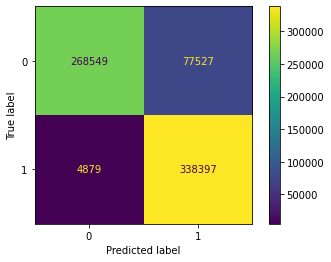

In [36]:
###############################################################################
## Plotting confusion matrix
###############################################################################
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.savefig("decision_tree_confusion_matrix.png", format="png")
plt.show()  # doctest: +SKIP
# td  sp  dp  pr  flg  ipkt ibyt